In [48]:
import torch
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesUV,
    FoVPerspectiveCameras,
    PointLights,
    MeshRenderer,
    RasterizationSettings,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    Textures,
    PerspectiveCameras

)
import cv2
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj

In [49]:
device='cuda:0'
fx = 2892.07091
fy = 2895.418
cx = 2003.92607
cy = 1454.19411

verts, faces, aux = load_obj('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/model_align.obj')
img = cv2.imread('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/images/0050.png')
verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture_image = Image.open('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/texture.jpg')
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)
texture_image = np.array(texture_image)[::-1, :, :].copy()
texture_image = torch.from_numpy(texture_image).float() / 255.0
texture_image = texture_image.reshape((1, 4096, 4096, 3))

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)



/home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [50]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes, load_obj
import math


camera_matrix = np.array([[fx, 0.00000000e+00, cx],
       [0.00000000e+00, fy, cy],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype = "double")

# 扭曲係數

dist_coeffs = np.zeros((4,1)) # 假設沒有鏡頭的成像扭曲 (no lens distortion)

class FaceMesh():

    def __init__(self, batch_size=1, kpt_num=478):

        base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
        options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
        self.detector = vision.FaceLandmarker.create_from_options(options)
        self.kpt_num = kpt_num
        self.batch_size = batch_size
        self.error_idx = 0

        # self.features_idx = [130, 133, 362, 359, 6, 195, 4, 61, 291]
        self.features_idx = [33, 263, 1, 61, 291, 199]

    def detect(
        self,
        img,
        type=None,
        exp=None,
        camID=None,
    ):
        features = np.zeros((len(self.features_idx), 2))
        # Convert the BGR image to RGB before processing.
        tmp_kpt = np.zeros((self.kpt_num, 2))
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
        results = self.detector.detect(img)
        for face_landmark in results.face_landmarks:
            for idx, data_point in enumerate(face_landmark):
                tmp_kpt[idx, 0] = data_point.x * img.width
                tmp_kpt[idx, 1] = data_point.y * img.height

        for idx, feat in enumerate(self.features_idx):
            features[idx] = tmp_kpt[feat]
                
        return features
    
mp_detect = FaceMesh()
c_verts, _, _ = load_obj('canonical_face_model.obj')
mp_point6  = [{"x":-0.9396189451217651,"y":1.2564451694488525,"z":-0.9755242466926575},{"x":-0.8838400840759277,"y":1.3033815622329712,"z":0.3997921943664551},{"x":-1.5201283693313599,"y":0.7055310606956482,"z":-0.24243663251399994},{"x":-0.9436807036399841,"y":0.17162324488162994,"z":-0.6040045619010925},{"x":-0.9147692918777466,"y":0.1978173404932022,"z":0.10889999568462372},{"x":-0.9223588705062866,"y":-0.5101673603057861,"z":-0.21605277061462402}]
mp_point6 = np.array([[point3d['x'],point3d['y'],point3d['z']] for point3d in mp_point6])
#Read 2D image

kpts = mp_detect.detect(img)
for i, kpt in enumerate(kpts):
    kpt = kpt.astype(np.int32)
    cv2.circle(img, (kpt[0], kpt[1]), 10, (255, 0, 0), -1)
    cv2.putText(img, str(i), (kpt[0], kpt[1]),cv2.FONT_HERSHEY_SIMPLEX,
  2, (0, 255, 255), 1, cv2.LINE_AA)
cv2.namedWindow('test', cv2.WINDOW_NORMAL)
cv2.imshow('test', cv2.resize(img, (1512, 2016)))
key = cv2.waitKey(0)
if key ==27:
    cv2.destroyAllWindows()
# 使用OpenCV的solvePnP函數來計算人臉的旋轉與位移
#(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix
#                                                              , dist_coeffs, flags=cv2.CV_ITERATIVE)
# 參數:
#   model_points 3維模型的座標點
#   image_points 2維圖像的座標點
#   camera_matrix 照像機矩陣
#   dist_coeffs 照像機扭曲係數
#   flags: cv2.SOLVEPNP_ITERATIVE
model_points=mp_point6
face_points = kpts

(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                              , dist_coeffs, useExtrinsicGuess = False, flags=cv2.SOLVEPNP_ITERATIVE)

R = cv2.Rodrigues(rotation_vector)[0]
t = translation_vector.T


print("Rotation Vector:\n {0}".format(R)) # 旋轉向量
print("Translation Vector:\n {0}".format(t)) # 位移向量

W0000 00:00:1698918086.488784  211298 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Rotation Vector:
 [[ 0.14004433  0.05875766  0.98840029]
 [ 0.01269366 -0.99826219  0.05754538]
 [ 0.99006386  0.00448752 -0.14054681]]
Translation Vector:
 [[-1.50322224  2.94552578  8.23917894]]


In [51]:
verts = torch.tensor(((R@verts.numpy().T).T+t), dtype=torch.float32)


In [52]:
#讀進所有的v, vt, f
total_lines = 0
with open(
        f'/media/aaron/work/KIRI/ME_1015/P11_MOUTH_RIGHT/model_align.obj',
        'r') as f:
    total_lines = len(f.readlines())

txt = ''
#只改v，其他不因obj不同而改變
with open(
        f'/media/aaron/work/KIRI/ME_1015/P11_MOUTH_RIGHT/model_align.obj',
        'r') as f:
    for i in range(7306):
        f.readline()
        txt += f'v {verts[i][0]} {verts[i][1]} {verts[i][2]}\n'
    for _ in range(7306, total_lines):

        txt += f.readline()
# with open('../test_data/test.obj', 'w') as w:

with open(f'test.obj', 'w') as w:
    w.write(txt)

In [53]:
meshes = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex.to(device))

In [54]:
focal = torch.tensor([fx, fy], dtype=torch.float32).to(device).unsqueeze(0)
princpt = torch.tensor([cx, cy], dtype=torch.float32).to(device).unsqueeze(0)
cameras = PerspectiveCameras(device=device, focal_length=-focal, principal_point=princpt, in_ndc=False, image_size=((4032, 3024),))

In [55]:
raster_settings = RasterizationSettings(
            image_size=[4032, 3024],
            blur_radius=0.0,
            faces_per_pixel=1,
            bin_size=0
        )
lights = PointLights(device=device, location=[[0.0, 1.0, -10.0]])


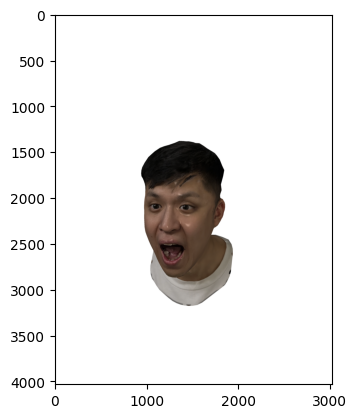

In [56]:
with torch.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(meshes, znear=0.0, zfar=1000.0)
    img = 255*images.cpu().contiguous().numpy()

    
    img = img.astype('uint8')
    img = img[0, :, :, :3]
    # cv2.imwrite(f'../test_data/img-{index+1}.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # img = cv2.rotate(img, cv2.ROTATE_180)
    cv2.imwrite('test.png', img)
    plt.imshow(img)